In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
df = pd.read_csv('../data/data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 121


In [3]:
def gera_corr_df(defect_name, df_original, df_normalized, feat_to_eixo, feat_to_type):
    # calcula correlações
    corr = df_original.corr()['severidade']
    # exclui informações não relevantes
    corr = corr.drop(['severidade', 'rotacao_calc', 'rotacao_calc_aprox'])
    corr = corr.to_frame('correlacao')
    corr['normalizado'] = False

    # calcula correlações
    corrnorm = df_normalized.corr()['severidade']
    # exclui informações não relevantes
    corrnorm = corrnorm.drop(['severidade', 'rotacao_calc', 'rotacao_calc_aprox'])
    corrnorm = corrnorm.to_frame('correlacao')
    corrnorm['normalizado'] = True

    corr = pd.concat([corr, corrnorm])

    # recupera nome das features como valores, não como index
    corr.reset_index(inplace=True)
    corr = corr.rename(columns = {'index':'feature'})
    # atribui eixo
    corr['eixo'] = corr['feature'].map(feat_to_eixo)
    # atribui categoria
    corr['categoria'] = corr['feature'].map(feat_to_type)
    # guarda sinal da correlação e torna todas positivas
    corr['positiva'] = corr['correlacao'].apply(lambda x: x>0)
    corr['correlacao'] = corr['correlacao'].abs()
    # classifica como desejado
    corr['normalizado'] = ~corr['normalizado']
    corr = corr.sort_values(ascending=False, by=['eixo', 'normalizado', 'correlacao'])
    corr['normalizado'] = ~corr['normalizado']

    return corr

def plot_correlations(corr):
    # gera plot 1
    fig, axs = plt.subplots(1, 3, figsize=(16,6), sharex=True)
    for i, eixo in enumerate(['radial', 'tangente', 'axial']):
        sns.barplot(y='feature', x='correlacao', data=corr.query('normalizado == False and eixo == "{}" '.format(eixo)),
                    orient='h', ax=axs[i], palette="viridis")
        axs[i].set_title('eixo ' + eixo)
    plt.suptitle('Correlação em cada eixo')
    plt.tight_layout()

    # gera plot 2
    fig, axs = plt.subplots(1, 3, figsize=(16,6), sharex=True)
    for i, eixo in enumerate(['radial', 'tangente', 'axial']):
        sns.barplot(y='feature', x='correlacao', data=corr.query('eixo == "{}" '.format(eixo)), 
                orient='h', ax=axs[i], hue='normalizado')
        axs[i].set_title('eixo ' + eixo)

    plt.suptitle('Ganho ao normalizar por eixo')
    plt.tight_layout()


def plot_detailed_comparisson(feature, defect_name, df_original, df_normalized):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20,5))
    fig.suptitle('Variação de "'+ defect_name +'" em relação a "' + feature + '"')

    sns.pointplot(data = df_original, x = 'severidade',
                  y = feature, hue = 'rotacao_calc_aprox', ax=ax1)
    sns.pointplot(data = df_normalized, x = 'severidade',
                  y = feature, hue = 'rotacao_calc_aprox', ax=ax2)

    ax1.set_title('Não normalizado')
    ax2.set_title('Normalizado')
    
    plt.show()

# automatiza plot do slopegraph
def plot_change_correlation(defect_type, df_original, df_normalized, decrescente=False, ax=None, cut=3, **plt_kwargs):

    corr = df_original.corr().abs()['severidade']
    corr = corr.drop(['severidade', 'rotacao_calc', 'rotacao_calc_aprox']).rename('original')

    corr_norm = df_normalized.corr().abs()['severidade']
    corr_norm = corr_norm.drop(['severidade', 'rotacao_calc', 'rotacao_calc_aprox']).rename('normalizado')

    compare = pd.concat([corr, corr_norm], axis=1)
    compare['diff'] = compare['normalizado'] - compare['original']
    compare = compare.sort_values('diff', ascending=decrescente)
    compare = compare.iloc[:cut]
    compare.pop('diff')

    sns.axes_style("white")
    if ax is None:
        ax = plt.gca()
    
    for i, feature in enumerate(compare.index):
        sns.lineplot(x=['1 original', '2 normalizado'], y=compare.iloc[i], color='black', marker='o', ax=ax)
        ax.text(-0.3, compare.iloc[i, 0], "{:.2f}".format(compare.iloc[i, 0]), fontsize=12)
        ax.text(1.05, compare.iloc[i, 1], "{:.2f}  {}".format(compare.iloc[i, 1], feature), fontsize=12)

    # Removendo o eixo y
    ax.axes.get_yaxis().set_visible(False)

    # Removendo os eixos
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(defect_type, fontsize=20)

    # Exibindo o gráfico
    plt.tight_layout()


### Provando a precisão da velocidade obtida pelo FFT do tacômetro

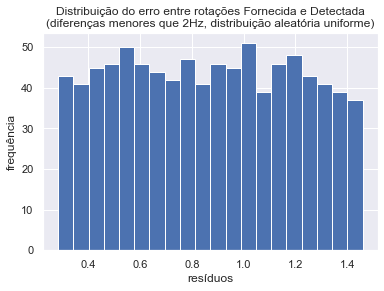

In [4]:
# distribuição do erro
plt.hist(df['rotacao_manual']-df['rotacao_calc'],20)
plt.title('Distribuição do erro entre rotações Fornecida e Detectada'+ 
          '\n(diferenças menores que 2Hz, distribuição aleatória uniforme)')
plt.xlabel('resíduos')
plt.ylabel('frequência')
plt.show()

# remove coluna de 'rotacao_manual', que é redundante con 'rotacao_calc'
df.pop('rotacao_manual');

In [5]:
# mapeia velocidade em intervalos decimais
decimals = (pd.cut(df['rotacao_calc'], bins=[0,15,25,35,45,55,65], labels=False)+1)*10
df.insert(3, 'rotacao_calc_aprox', decimals)

# filtra velocidades acima de 30 Hz
df = df.query('rotacao_calc > 30')

# Organizando as features por categoria e por eixo

In [6]:
# mapeia cada categoria de feature para suas instâncias
columns = list(df.columns)
feat_type = {
    'harmonico 1': [col for col in columns if '1h' in col],
    'harmonico 2': [col for col in columns if '2h' in col],
    'harmonico 3': [col for col in columns if '3h' in col],
    'entropia':    [col for col in columns if 'entr' in col],
    'curtose':     [col for col in columns if 'kurt' in col],
    'RMS':         [col for col in columns if 'timestat_rms' in col],
    'tempstat':    [col for col in columns if 'timestat' in col],
    'freqstat':    [col for col in columns if 'freqstat' in col],
    'fase':        [col for col in columns if 'phase' in col],
    # 'descritivos': ['condicao', severidade, 'rotacao_manual', 'rotacao_calc'],
}

# faz o mapeamento inverso, do nome de cada feature para a sua categoria
feat_to_type = {v[i]: k for k, v in feat_type.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in feat_type.items():
    k = k +': '
    print('{:>13}'.format(k), i)
    listed.extend(i)

# mosta todas as outras colunas
print('{:>13}'.format('descritivos: '), [i for i in df.columns if i not in listed])

harmonico 1:  ['ax1_1h', 'ax2_1h', 'rad1_1h', 'rad2_1h', 'tg1_1h', 'tg2_1h', 'freq_ax_1h']
harmonico 2:  ['ax1_2h', 'ax2_2h', 'rad1_2h', 'rad2_2h', 'tg1_2h', 'tg2_2h', 'freq_ax_2h']
harmonico 3:  ['ax1_3h', 'ax2_3h', 'rad1_3h', 'rad2_3h', 'tg1_3h', 'tg2_3h', 'freq_ax_3h']
   entropia:  ['ax1_timestat_entropy', 'ax2_timestat_entropy', 'rad1_timestat_entropy', 'rad2_timestat_entropy', 'tg1_timestat_entropy', 'tg2_timestat_entropy']
    curtose:  ['ax1_timestat_kurt', 'ax2_timestat_kurt', 'rad1_timestat_kurt', 'rad2_timestat_kurt', 'tg1_timestat_kurt', 'tg2_timestat_kurt', 'ax1_timestat_kurt_f', 'ax2_timestat_kurt_f', 'rad1_timestat_kurt_f', 'rad2_timestat_kurt_f', 'tg1_timestat_kurt_f', 'tg2_timestat_kurt_f']
        RMS:  ['ax1_timestat_rms', 'ax2_timestat_rms', 'rad1_timestat_rms', 'rad2_timestat_rms', 'tg1_timestat_rms', 'tg2_timestat_rms']
   tempstat:  ['ax1_timestat_rms', 'ax2_timestat_rms', 'rad1_timestat_rms', 'rad2_timestat_rms', 'tg1_timestat_rms', 'tg2_timestat_rms', 'ax1_time

In [7]:
# mapeia cada eixo de captação para suas instâncias
eixo = {
    'axial':     [col for col in columns if 'ax' in col],
    'radial':    [col for col in columns if 'rad' in col],
    'tangente':  [col for col in columns if 'tg' in col],
}

# faz o mapeamento inverso, do nome de cada feature para o seu eixo
feat_to_eixo = {v[i]: k for k, v in eixo.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in eixo.items():
    k = k +': '
    print('{:>11}'.format(k), i[:7], '\n           ', i[7:], '\n')
    listed.extend(i)

    axial:  ['ax1_1h', 'ax2_1h', 'freq_ax_1h', 'ax1_2h', 'ax2_2h', 'freq_ax_2h', 'ax1_3h'] 
            ['ax2_3h', 'freq_ax_3h', 'ax1_phase', 'ax2_phase', 'ax1_timestat_rms', 'ax2_timestat_rms', 'ax1_timestat_sra', 'ax2_timestat_sra', 'ax1_timestat_kurt', 'ax2_timestat_kurt', 'ax1_timestat_sqew', 'ax2_timestat_sqew', 'ax1_timestat_peak', 'ax2_timestat_peak', 'ax1_timestat_abs_max', 'ax2_timestat_abs_max', 'rad1_timestat_abs_max', 'rad2_timestat_abs_max', 'tg1_timestat_abs_max', 'tg2_timestat_abs_max', 'ax1_timestat_crest', 'ax2_timestat_crest', 'ax1_timestat_impulse', 'ax2_timestat_impulse', 'ax1_timestat_margin', 'ax2_timestat_margin', 'ax1_timestat_shape', 'ax2_timestat_shape', 'ax1_timestat_kurt_f', 'ax2_timestat_kurt_f', 'ax1_timestat_entropy', 'ax2_timestat_entropy', 'ax1_freqstat_fc', 'ax2_freqstat_fc', 'ax1_freqstat_rmsf', 'ax2_freqstat_rmsf', 'ax1_freqstat_rvf', 'ax2_freqstat_rvf'] 

   radial:  ['rad1_1h', 'rad2_1h', 'rad1_2h', 'rad2_2h', 'rad1_3h', 'rad2_3h', 'rad1_phase'] 
 

O primeiro procedimento é separar os conjuntos.

In [8]:
# conta número de samples para cada condicao
df['condicao'].value_counts()

imbalance                  205
vertical-misalignment      187
horizontal-misalignment    123
normal                      30
Name: condicao, dtype: int64

Será averiguada a relvância da normalização das variáveis em relação à velocidade de rotação de cada ensaio.

In [9]:
# gera cópia profunda para alterar os valores internos sem corromper originais
df_norm = df.copy(deep=True)

# normaliza cada um por 1/rotacao_calc
df_norm.iloc[:, 4:] = df.iloc[:, 4:].div(df['rotacao_calc'], axis=0)

In [10]:
df.query("condicao == 'imbalance' or condicao == 'normal'")

,condicao,severidade,rotacao_calc,rotacao_calc_aprox,ax1_1h,ax2_1h,rad1_1h,rad2_1h,tg1_1h,tg2_1h,...,rad1_freqstat_rmsf,rad2_freqstat_rmsf,tg1_freqstat_rmsf,tg2_freqstat_rmsf,ax1_freqstat_rvf,ax2_freqstat_rvf,rad1_freqstat_rvf,rad2_freqstat_rvf,tg1_freqstat_rvf,tg2_freqstat_rvf
516,imbalance,10.0,31.0,30,19.250041,2.863738,24.414359,0.584683,7.049191,8.362220,...,1030.422342,861.343022,1145.371605,888.219822,623.954550,524.406914,626.765305,589.449067,651.260229,680.295606
517,imbalance,10.0,32.0,30,20.985573,3.724069,27.396162,0.871062,9.297136,11.543725,...,1050.606102,855.355547,1125.261306,899.534755,617.457103,508.602183,621.634157,587.664525,648.803611,678.938461
518,imbalance,10.0,32.8,30,20.352680,2.884689,23.832221,0.594529,11.699815,10.711867,...,1062.419835,864.019799,1123.477198,889.769749,622.646189,521.469923,622.473355,586.908785,657.714296,679.997677
519,imbalance,10.0,33.6,30,21.093277,2.652975,22.914116,0.546636,12.260075,10.794463,...,1087.300326,868.548039,1156.417089,873.553228,606.642431,524.497457,599.076784,589.645482,639.104391,667.188083
520,imbalance,10.0,35.2,40,28.739751,3.310156,25.554186,0.651620,16.183295,18.495487,...,1109.661698,875.454608,1191.369364,935.477082,633.057464,542.743092,585.247101,588.707738,620.535249,691.837001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,normal,0.0,56.6,60,16.818741,2.656076,19.138711,0.687831,5.424467,18.556028,...,1029.979251,752.088179,1110.082975,979.944477,630.114266,459.245085,554.840039,544.170576,581.017353,664.618451
876,normal,0.0,57.4,60,11.348093,1.490324,12.580304,0.411895,3.367707,12.284815,...,1022.094603,762.081747,1106.897597,952.666714,631.427631,463.752565,559.048625,550.937031,588.115801,656.355420
877,normal,0.0,58.2,60,13.832032,1.443718,15.306095,0.431275,3.928379,15.453647,...,1027.155944,784.331658,1117.993826,955.224130,632.191930,475.596941,555.572706,561.344353,588.413411,663.363691
878,normal,0.0,59.0,60,18.069033,1.552674,18.284915,0.437273,4.780992,18.287953,...,1028.741387,797.963946,1121.530434,949.521202,636.227190,474.053016,546.657413,567.344421,592.142659,655.614176


In [11]:
# separa cada tipo de condicao em um dataframe específico
df_desbal      =      df.query("condicao == 'imbalance' or condicao == 'normal'")
df_des_ve      =      df.query("condicao == 'vertical-misalignment' or condicao == 'normal'")
df_des_ho      =      df.query("condicao == 'horizontal-misalignment' or condicao == 'normal'")

# cria dicionário que aponta o nome do condicao para o seu DataFrame
fault_to_df = {
    'imbalance'         :   df_desbal,
    'vertical-misalignment'  :   df_des_ve,
    'horizontal-misalignment':   df_des_ho,
}


# repete as operações para df normalizado
df_desbal_norm = df_norm.query("condicao == 'imbalance' or condicao == 'normal'")
df_des_ve_norm = df_norm.query("condicao == 'vertical-misalignment' or condicao == 'normal'")
df_des_ho_norm = df_norm.query("condicao == 'horizontal-misalignment' or condicao == 'normal'")

fault_to_normalized_df = {
    'imbalance'         :   df_desbal_norm,
    'vertical-misalignment'  :   df_des_ve_norm,
    'horizontal-misalignment':   df_des_ho_norm,
}

In [12]:
# descarta a coluna 'condicao' de cada df, pois é informação redundante
for _, dfram in fault_to_df.items():
    dfram.pop('condicao')
for _, dfram in fault_to_normalized_df.items():
    dfram.pop('condicao')
    
fault_to_df['vertical-misalignment'].head()

,severidade,rotacao_calc,rotacao_calc_aprox,ax1_1h,ax2_1h,rad1_1h,rad2_1h,tg1_1h,tg2_1h,freq_ax_1h,...,rad1_freqstat_rmsf,rad2_freqstat_rmsf,tg1_freqstat_rmsf,tg2_freqstat_rmsf,ax1_freqstat_rvf,ax2_freqstat_rvf,rad1_freqstat_rvf,rad2_freqstat_rvf,tg1_freqstat_rvf,tg2_freqstat_rvf
216,0.51,30.8,30,18.589909,1.821137,9.381634,0.346572,2.316040,9.261043,31.6,...,1043.818246,810.901727,1179.268975,962.653530,590.454851,480.593678,569.154215,576.728288,632.123283,679.180121
217,0.51,31.6,30,20.206224,2.164904,10.222074,0.453903,1.958848,12.363878,32.4,...,1042.724929,813.809823,1144.159266,937.727268,583.023266,489.158303,554.701252,574.425407,622.054507,674.969274
218,0.51,32.6,30,18.538231,2.818024,10.413530,0.542759,3.078609,14.888329,33.4,...,1051.798883,811.298890,1171.830447,946.868323,581.260257,503.435432,554.884455,576.460769,614.577206,677.709240
219,0.51,33.4,30,12.779629,3.196664,6.883467,0.568992,2.565438,9.928871,34.2,...,1053.168006,790.234054,1165.862708,958.620150,599.819408,489.470047,560.082322,566.016783,617.806971,686.448111
220,0.51,34.4,30,18.572563,2.297680,9.162564,0.425836,3.825272,15.313859,35.2,...,1058.534266,816.435055,1158.673619,970.314715,581.498934,497.916175,549.311438,574.722054,608.451338,673.321778


# Análise de correlação

## imbalance

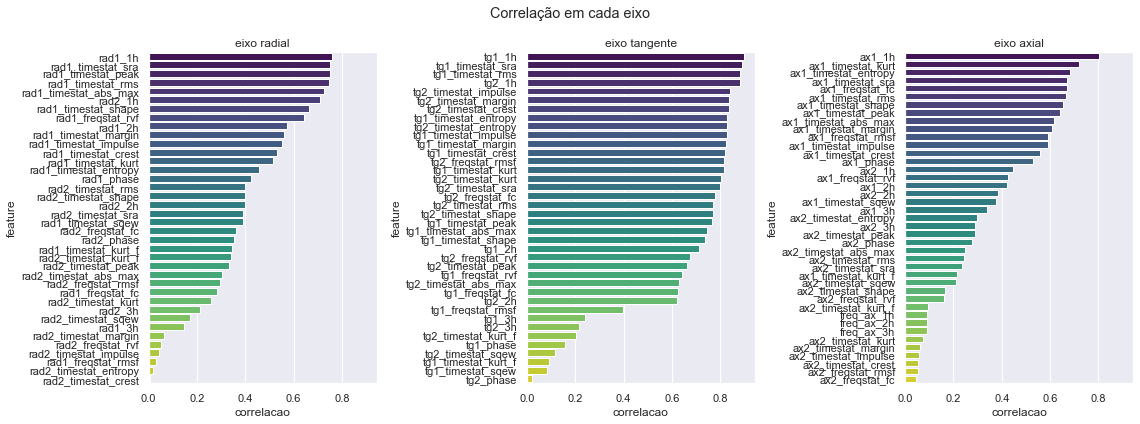

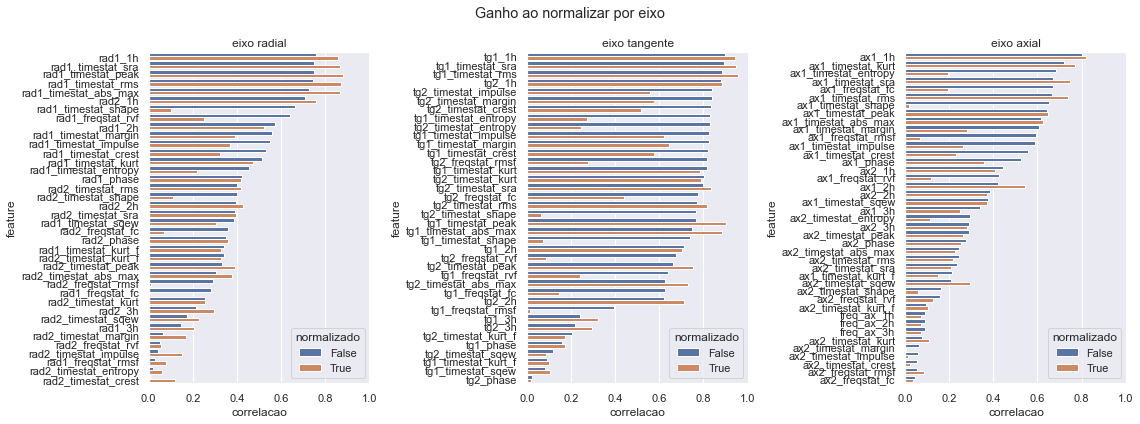

In [13]:
corr_df = gera_corr_df('imbalance', df_desbal, df_desbal_norm, feat_to_eixo, feat_to_type)

plot_correlations(corr_df)

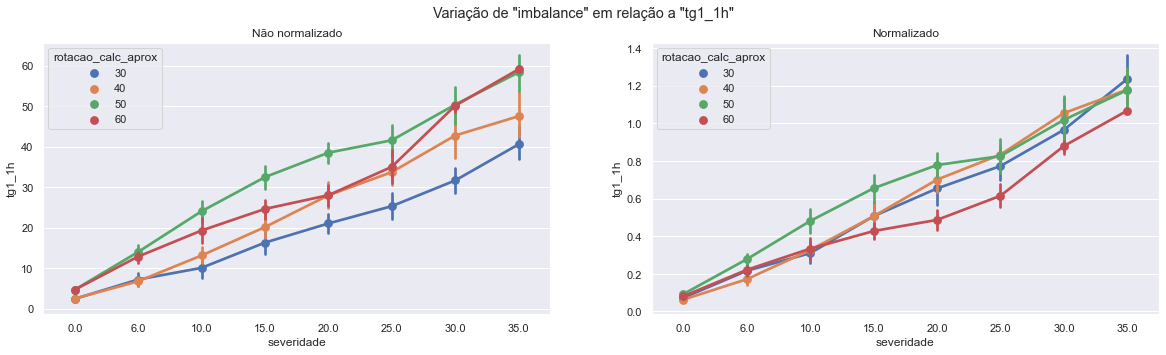

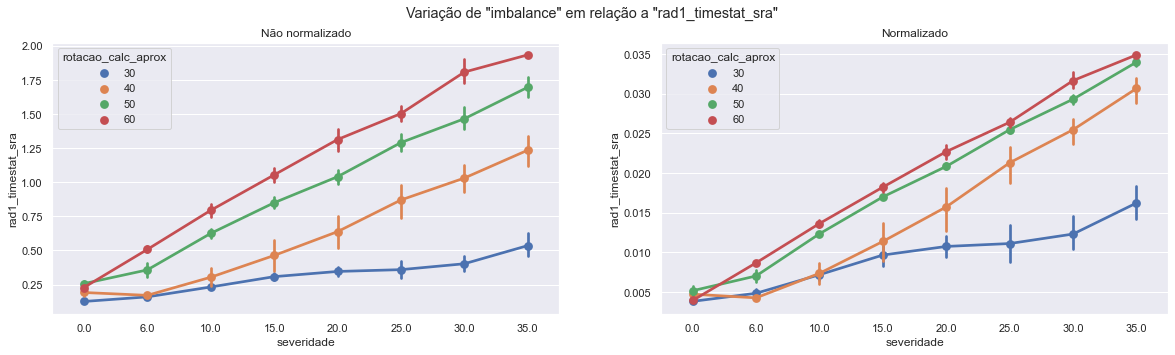

In [15]:
plot_detailed_comparisson('tg1_1h', 'imbalance', df_desbal, df_desbal_norm)
plot_detailed_comparisson('rad1_timestat_sra', 'imbalance', df_desbal, df_desbal_norm)

## Desalinhamento vertical

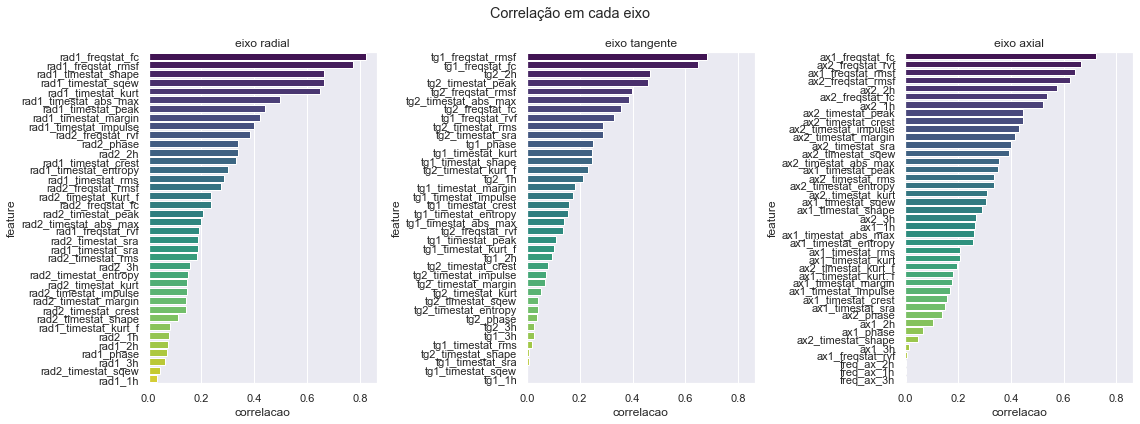

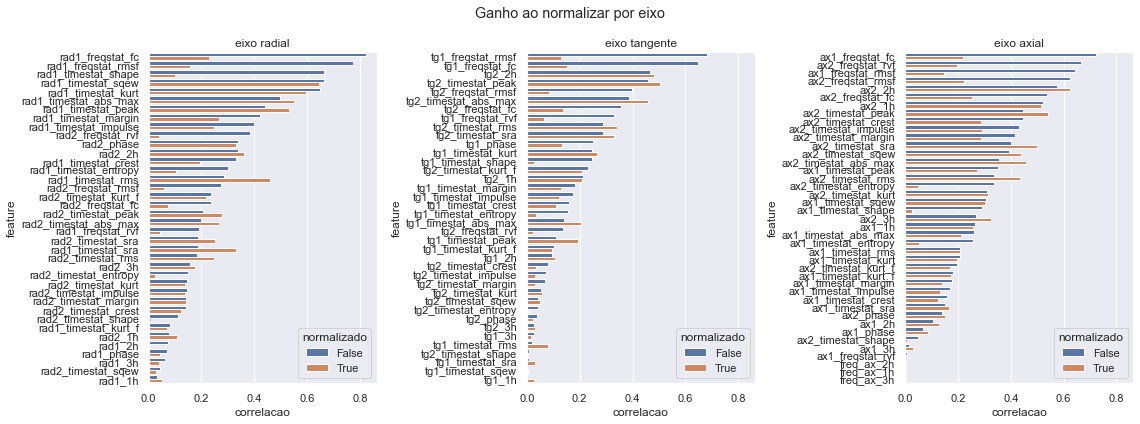

In [16]:
corr_df = gera_corr_df('vertical-misalignment', df_des_ve, df_des_ve_norm, feat_to_eixo, feat_to_type)

plot_correlations(corr_df)

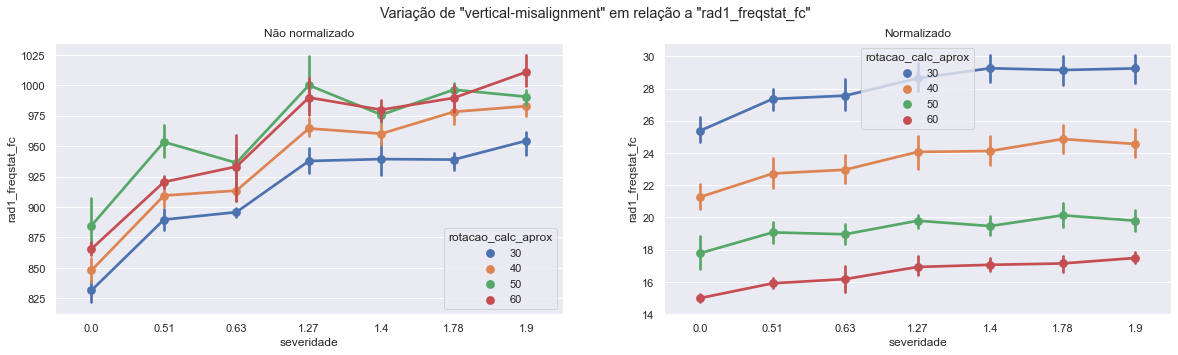

In [23]:
plot_detailed_comparisson('rad1_freqstat_fc', 'vertical-misalignment', df_des_ve, df_des_ve_norm)

## Desalinhamento horizontal

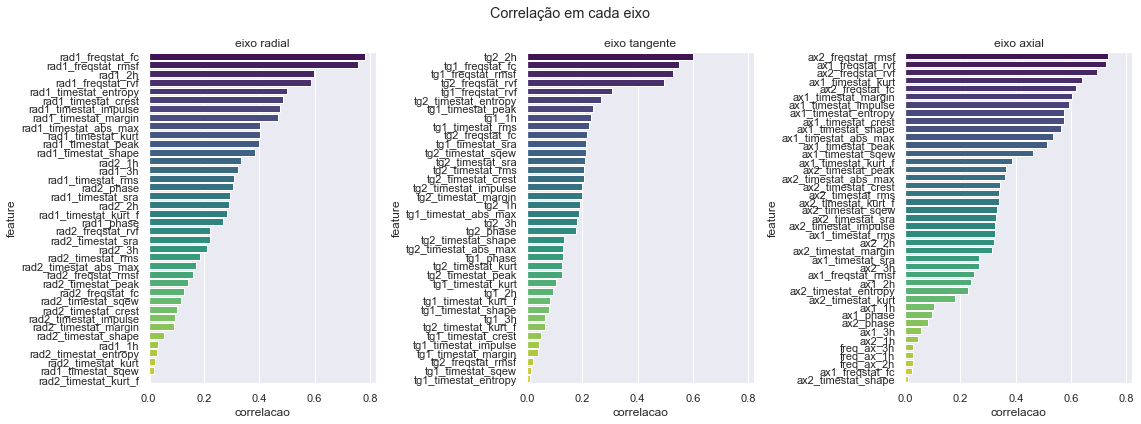

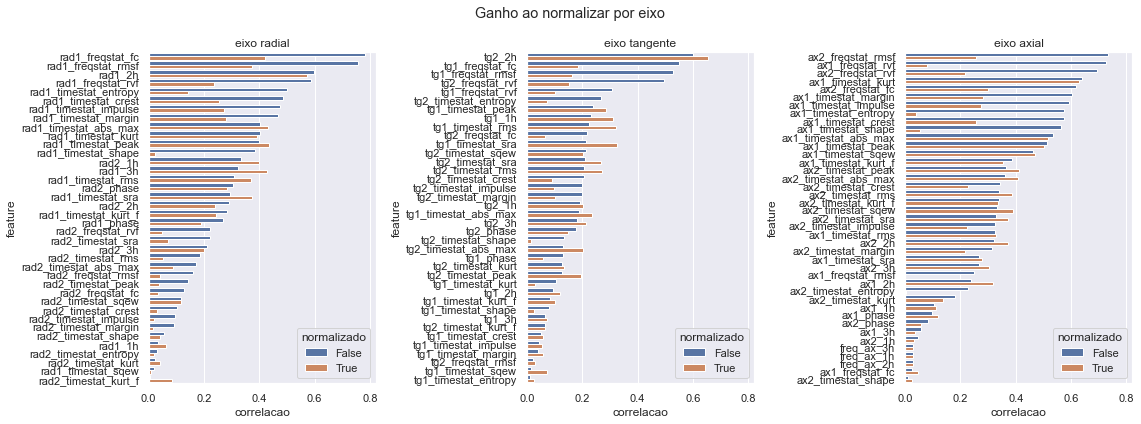

In [18]:
corr_df = gera_corr_df('horizontal-misalignment', df_des_ho, df_des_ho_norm, feat_to_eixo, feat_to_type)

plot_correlations(corr_df)

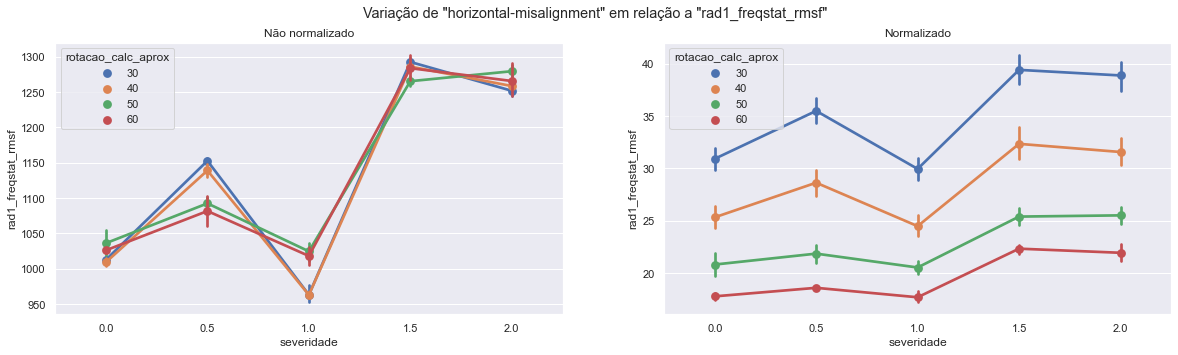

In [25]:
plot_detailed_comparisson('rad1_freqstat_rmsf', 'horizontal-misalignment', df_des_ho, df_des_ho_norm)

## Mudaças na correlação após normalização

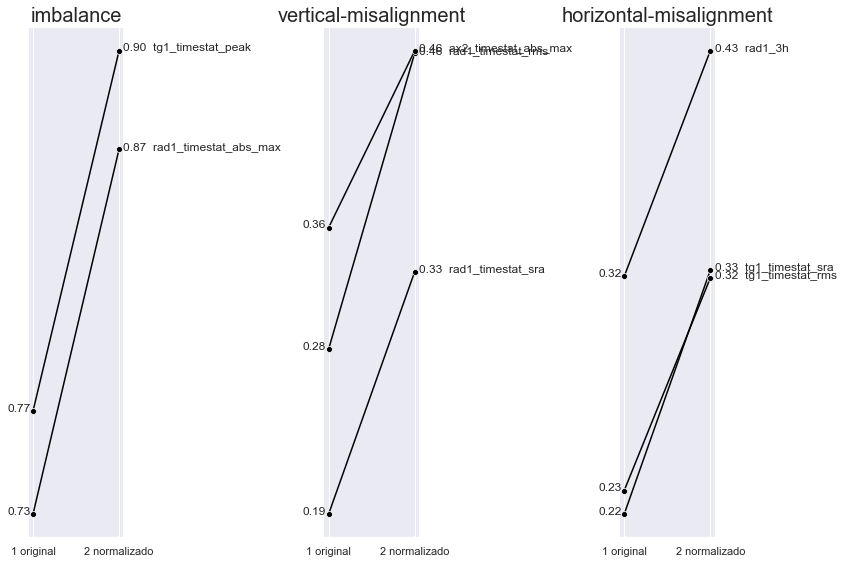

In [20]:
# plota maiores crescimentos 
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

plot_change_correlation('imbalance',          df_desbal, df_desbal_norm, ax=ax[0], cut=2)
plot_change_correlation('vertical-misalignment',   df_des_ve, df_des_ve_norm, ax=ax[1])
plot_change_correlation('horizontal-misalignment', df_des_ho, df_des_ho_norm, ax=ax[2])

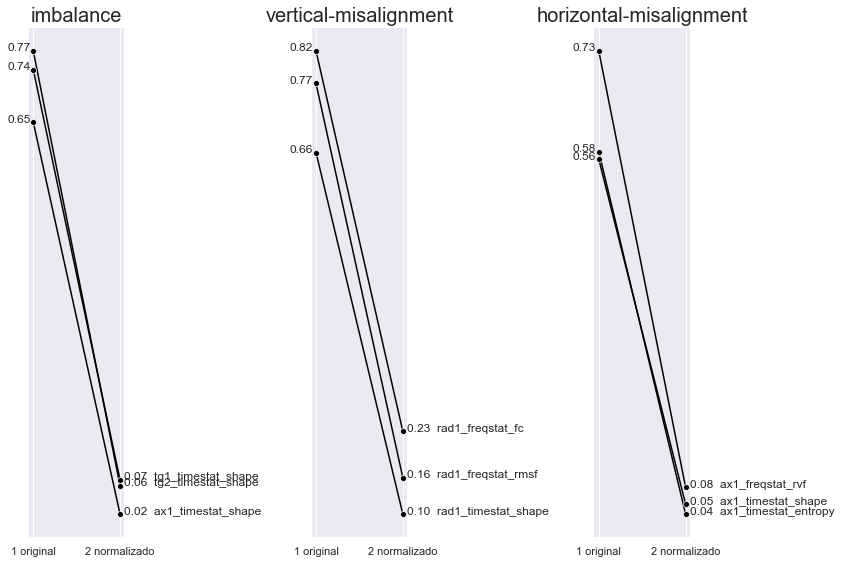

In [21]:
# plota maiores decrescimentos
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

plot_change_correlation('imbalance',          df_desbal, df_desbal_norm, decrescente=True, ax=ax[0])
plot_change_correlation('vertical-misalignment',   df_des_ve, df_des_ve_norm, decrescente=True, ax=ax[1])
plot_change_correlation('horizontal-misalignment', df_des_ho, df_des_ho_norm, decrescente=True, ax=ax[2])